In [1]:
import math, time
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import keras
from keras.initializers import glorot_uniform
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM


Using TensorFlow backend.


In [2]:
df = pd.read_csv('AMZN.csv')

In [5]:
df.describe()
n = df.isnull().sum(axis=0)
df.shape

(3999, 3)

In [4]:
df= df.loc[:, ['Open', 'High', 'Close']]
df=df.dropna()
df.head()

,Open,High,Close
1,10.58,10.65,9.95
2,10.10,10.30,10.12
3,10.32,11.04,10.53
4,10.54,10.83,10.08
5,10.08,10.15,9.81


In [38]:
df = df/(10^(len(str(df.iloc[0,0]).split('.')[0])-1))
df.head()

,Open,High,Close
1,0.961818,0.968182,0.904545
2,0.918182,0.936364,0.920000
3,0.938182,1.003636,0.957273
4,0.958182,0.984545,0.916364
5,0.916364,0.922727,0.891818


In [39]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = int(round(0.9 * result.shape[0]))
    train = result[:row, :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[row:, :-1]
    y_test = result[row:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [58]:
def build_model(layers):
    d = 0.2
    init = glorot_uniform(seed = 69)
    #glorot_uniform - the way to set the initial random weights of Keras layers.
    model = Sequential()
    model.add(LSTM(32, input_shape=(layers[0], layers[1]), return_sequences=True, kernel_initializer = init))
    #the return_sequences is set to False in Keras RNN layers, and this means the RNN layer will only return the last hidden state output
    model.add(Dropout(d))
    model.add(LSTM(32, return_sequences=True, kernel_initializer = init))
    model.add(Dropout(d))
    model.add(LSTM(32, return_sequences=False, kernel_initializer = init))
    model.add(Dropout(d))
    model.add(Dense(8,kernel_initializer=init ,activation='softmax'))        
    model.add(Dense(1,kernel_initializer= init ,activation='softmax'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

In [59]:
window = 22
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (3578, 22, 3)
y_train (3578,)
X_test (398, 22, 3)
y_test (398,)


C:\Users\vivek\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


# Loading the model sequence structure


In [60]:
model = build_model([window, 3])

## Executing the model & RMS/RMSE results

In [61]:
stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta= 0.5 , patience=3, verbose=2, mode='auto')
start_time = time.time()

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_test, y_test),
#     validation_split=0.1,
#     callbacks = [stop],
    verbose = 2)

print('\nTime taken for training: %.2f minutes'%((time.time()-start_time)/60))

Train on 3578 samples, validate on 398 samples
Epoch 1/20
 - 4s - loss: 774.9747 - accuracy: 0.0000e+00 - val_loss: 0.3555 - val_accuracy: 0.0025
Epoch 2/20
 - 2s - loss: 774.9747 - accuracy: 0.0000e+00 - val_loss: 0.3555 - val_accuracy: 0.0025
Epoch 3/20
 - 3s - loss: 774.9747 - accuracy: 0.0000e+00 - val_loss: 0.3555 - val_accuracy: 0.0025
Epoch 4/20
 - 3s - loss: 774.9747 - accuracy: 0.0000e+00 - val_loss: 0.3555 - val_accuracy: 0.0025
Epoch 5/20
 - 3s - loss: 774.9747 - accuracy: 0.0000e+00 - val_loss: 0.3555 - val_accuracy: 0.0025
Epoch 6/20
 - 3s - loss: 774.9747 - accuracy: 0.0000e+00 - val_loss: 0.3555 - val_accuracy: 0.0025
Epoch 7/20
 - 3s - loss: 774.9747 - accuracy: 0.0000e+00 - val_loss: 0.3555 - val_accuracy: 0.0025
Epoch 8/20
 - 3s - loss: 774.9747 - accuracy: 0.0000e+00 - val_loss: 0.3555 - val_accuracy: 0.0025
Epoch 9/20
 - 2s - loss: 774.9747 - accuracy: 0.0000e+00 - val_loss: 0.3555 - val_accuracy: 0.0025
Epoch 10/20
 - 2s - loss: 774.9747 - accuracy: 0.0000e+00 - va

In [62]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 774.97 MSE (27.84 RMSE)
Test Score: 0.36 MSE (0.60 RMSE)


## Predictions vs Real results

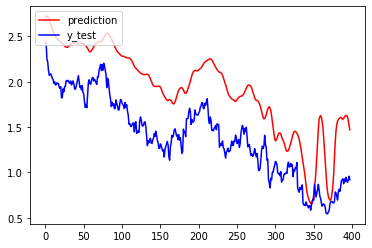

In [63]:
plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()